# Importing libraries

In [3]:
# standard libraries
import regex as re

# data processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
# from sklearn.feature_extraction.text import CountVectorizer

# display
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# natural language processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Kaggle (dataset download)
import kagglehub

# Required downloads for nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

# Download the dataset with KaggleHub
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 11.1M/11.1M [00:01<00:00, 7.27MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


# Loading the dataset

In [4]:
df = pd.read_csv(path + '/Combined Data.csv', index_col=0)
df_02 = df.copy()
df_02.sample(10)

statement                status
51168  Natural brain dampener I have recently been ex...  Personality disorder
15920  I do not want to live and nothing helps. I wis...            Depression
10672  i have no other options but to go on anti depr...            Depression
22417  I am blanking on my age. I legit cannot rememb...              Suicidal
16176  But it died tonight so here is hoping that ton...            Depression
11868  I have had a problem with building **intimacy*...            Depression
34917  Muscle Twitch Around Knee Hey guys, only just ...               Anxiety
12258  I have a close friend who is going through a l...            Depression
48043  California rocketfuel (Effexor75mg + Mirtazepi...            Depression
16660  I posted this on multiple threads. I hope it c...            Depression

# EDA

In [5]:
df_02.shape

(53043, 2)

In [6]:
df_02 = df_02.drop(df_02[df_02["statement"].str.len() <= 6].index)
df_02.shape

(52906, 2)

In [7]:
df_02.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52906 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52544 non-null  object
 1   status     52906 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
df_02.isnull().sum()

statement    362
status         0
dtype: int64

In [9]:
df_02.dropna(inplace=True)
df_02.isnull().sum()

statement    0
status       0
dtype: int64

In [10]:
df_02.duplicated().sum()

1561

In [11]:
df_02.drop_duplicates(inplace=True)
df_02.duplicated().sum()

0

In [12]:
df_02.describe()

statement  status
count                                               50983   50983
unique                                              50966       7
top     Recently I have started this internship and mo...  Normal
freq                                                    2   15934

Text(0.5, 1.0, 'Distribution of Mental Health Statuses')

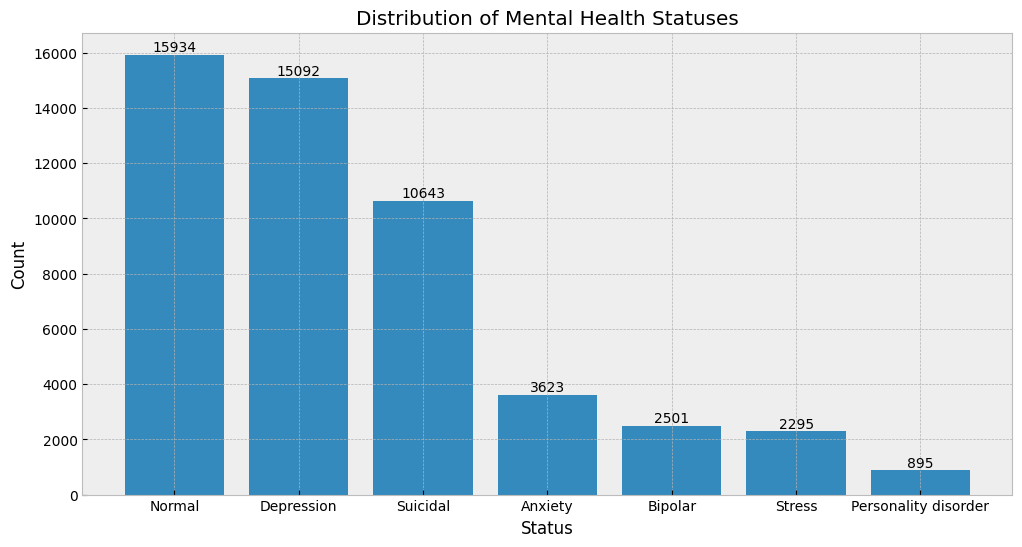

In [13]:
plt.figure(figsize=(12, 6))
status_counts = df_02['status'].value_counts()
plt.style.use("bmh")

for i, v in enumerate(status_counts):
  plt.text(i, v, str(v), ha='center', va='bottom')

plt.bar(status_counts.index, status_counts.values)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Mental Health Statuses')

# Data preprocessing

In [14]:
def preprocess_text(text):

    # convert text to lowercase
    text = str(text).lower()

    # removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # removing any text that starts with @
    text = re.sub(r'@\S+', '', text)

    # removing any text that starts with #
    text = re.sub(r'#\S+', '', text)

    # removing words that contain numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # removing extra spaces
    text = re.sub(r'\s+', ' ', text)

    # removing line breaks
    text = re.sub(r'\n', ' ', text)

    # removing punctuations marks
    text = re.sub(r'[^\w\s]', '', text)

    # tokenization
    tokens = word_tokenize(text)

    # filter stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # joining the tokens back into a chain
    text = ' '.join(tokens)

    return text.split()

In [15]:
df_02['text_clean'] = df_02['statement'].apply(preprocess_text)
df_02.sample(10)

statement      status  \
33561                                everyone likes him.      Normal   
3635      keep on shouting there don't understand w mahh      Normal   
11433  Life's still swell. I have an amazing husband,...    Suicidal   
26412  I just want the pain to go away I need support...  Depression   
5768   To be loved means "Eternal life in someone's h...      Normal   
23706  I do not really know how else to title this ot...    Suicidal   
3827                   wong kopen karo ora kie ncen bedo      Normal   
2857                Do you have any school holidays yet?      Normal   
42588  why do i keep looking i know that what i read ...      Normal   
10294  I want to die, pain is unbearable there is no ...    Suicidal   

                                              text_clean  
33561                                  [everyone, likes]  
3635         [keep, shouting, dont, understand, w, mahh]  
11433  [lifes, still, swell, amazing, husband, specta...  
26412  [want, pain, go, away, need, support, feeling,...  
5768      [loved, means, eternal, life, someones, heart]  
23706  [really, know, else, title, really, struggling...  
3827           [wong, kopen, karo, ora, kie, ncen, bedo]  
2857                             [school, holidays, yet]  
42588  [keep, looking, know, read, gon, na, hurt, sti...  
10294  [want, die, pain, unbearable, one, talk, night...

In [16]:
df_02 = df_02.drop(df_02[df_02["text_clean"].str.len() <= 3].index)
df_02.shape

(45796, 3)

In [17]:
lematizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    lemmatized_tokens = [lematizer.lemmatize(token, pos="v") for token in tokens]
    return ' '.join(lemmatized_tokens)

df_02['text_lematized'] = df_02['text_clean'].apply(lemmatize_text)
df_02.sample(10)

statement  \
4585   Isn't it weird, going out with a friend who fi...   
44947  helenthornber i dunno but i used to get fruits...   
50124  Mixed episode Does anyone have any tips on dea...   
51172  What’s your experience talking to a GP in the ...   
1253               Why do you miss it? Ha koe ki sopone?   
28380  Context: My father-in-law is/was the ultimate ...   
33201               well, you're supposed to be working.   
29526  Email her? She lives in his hometown, so an in...   
24675  I feel like i lose the purpose of my life. I h...   
5185                          Q SE MURP JYP???? ALFIN???   

                     status  \
4585                 Normal   
44947                Normal   
50124               Bipolar   
51172  Personality disorder   
1253                 Normal   
28380                Normal   
33201                Normal   
29526                Normal   
24675              Suicidal   
5185                 Normal   

                                              text_clean  \
4585   [isnt, weird, going, friend, fights, usually, ...   
44947  [helenthornber, dunno, used, get, fruitsalads,...   
50124  [mixed, episode, anyone, tips, dealing, mixed,...   
51172  [whats, experience, talking, gp, uk, avpd, ive...   
1253                         [miss, ha, koe, ki, sopone]   
28380  [context, fatherinlaw, iswas, ultimate, handym...   
33201                   [well, youre, supposed, working]   
29526  [email, lives, hometown, inperson, meeting, po...   
24675  [feel, like, lose, purpose, life, become, sens...   
5185                           [q, se, murp, jyp, alfin]   

                                          text_lematized  
4585   isnt weird go friend fight usually call lu uh ...  
44947  helenthornber dunno use get fruitsalads blackj...  
50124  mix episode anyone tip deal mix episode really...  
51172  whats experience talk gp uk avpd ive always fi...  
1253                               miss ha koe ki sopone  
28380  context fatherinlaw iswas ultimate handyman co...  
33201                            well youre suppose work  
29526  email live hometown inperson meet possible thi...  
24675  feel like lose purpose life become sensitive e...  
5185                                 q se murp jyp alfin

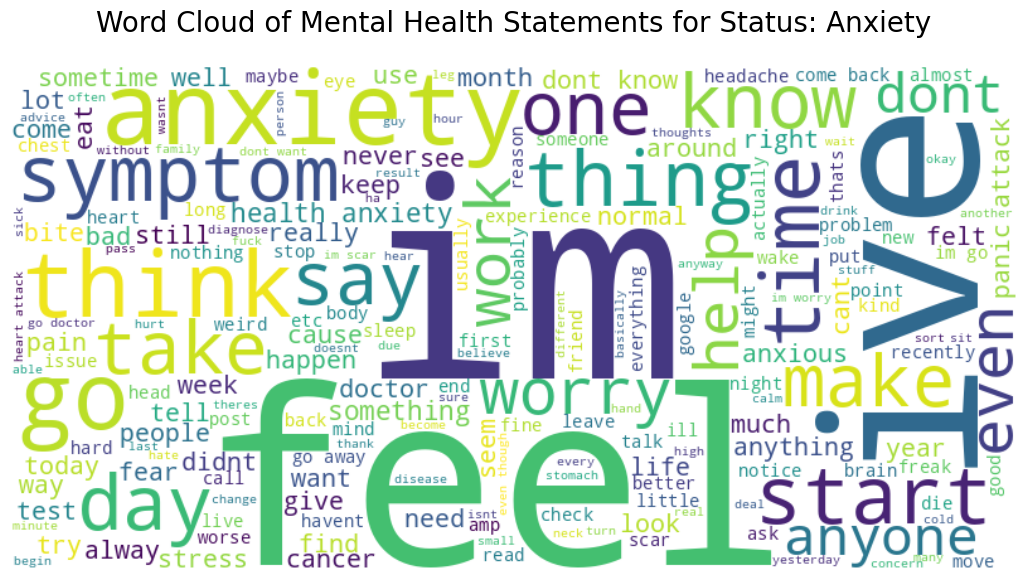

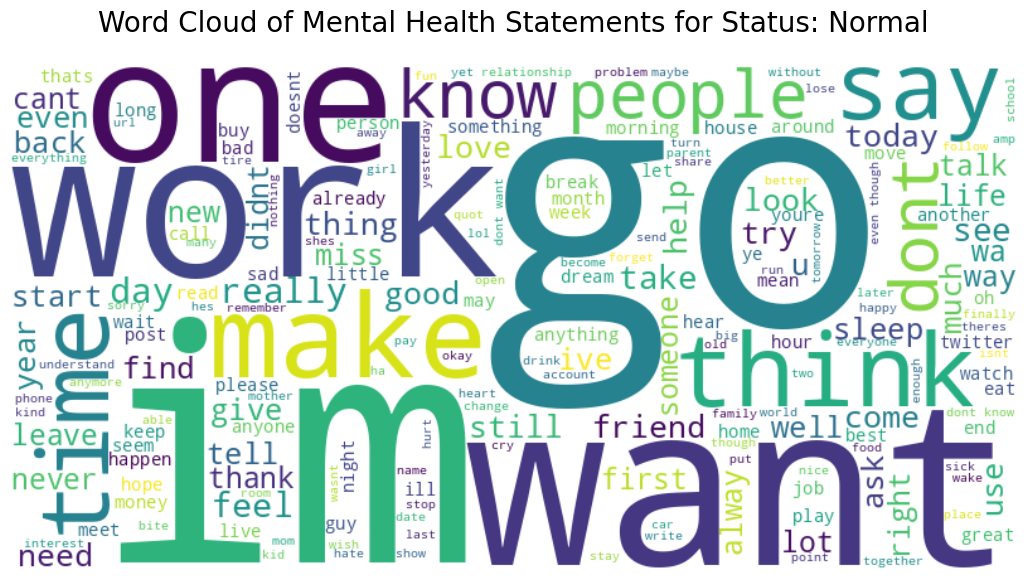

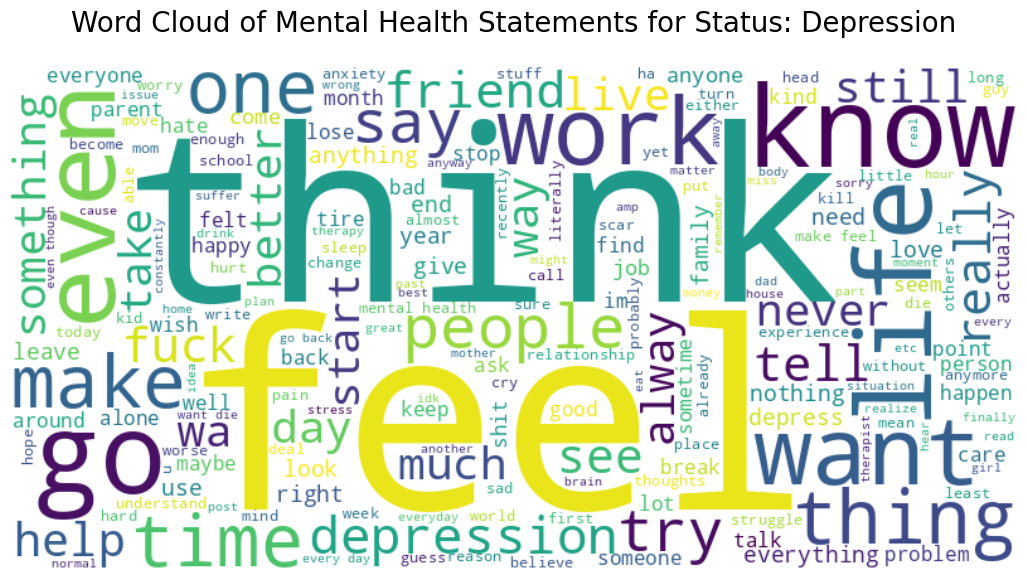

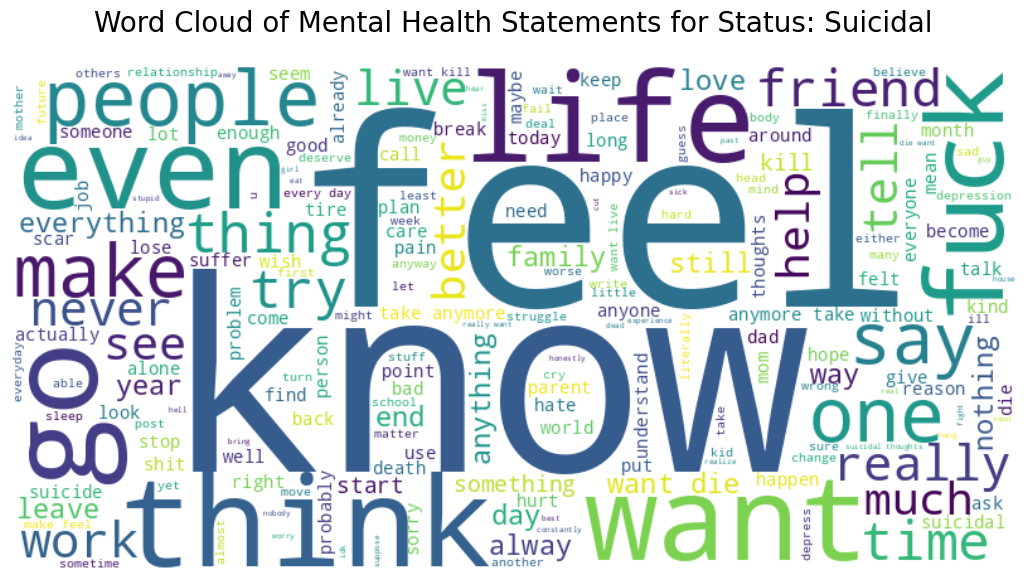

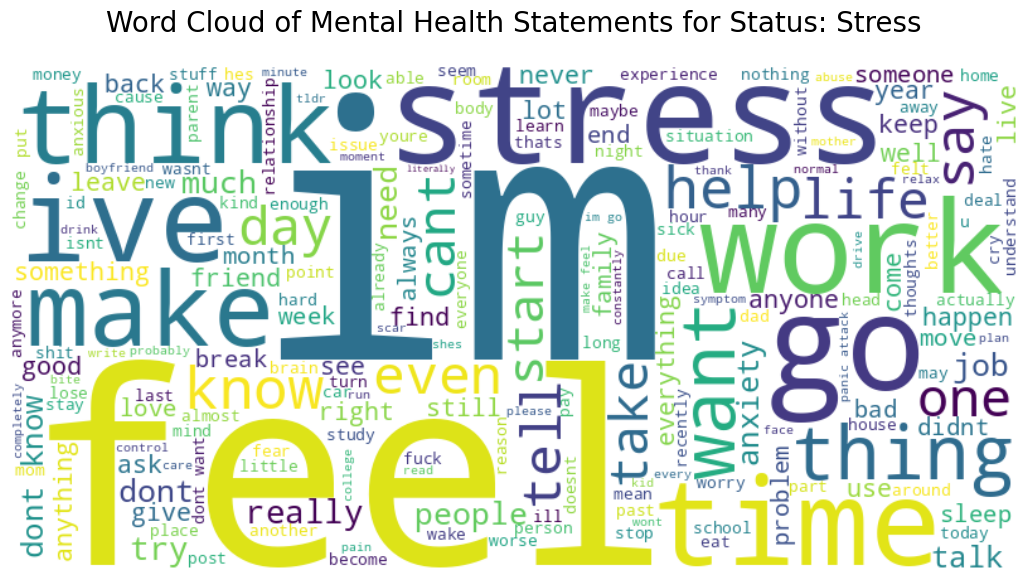

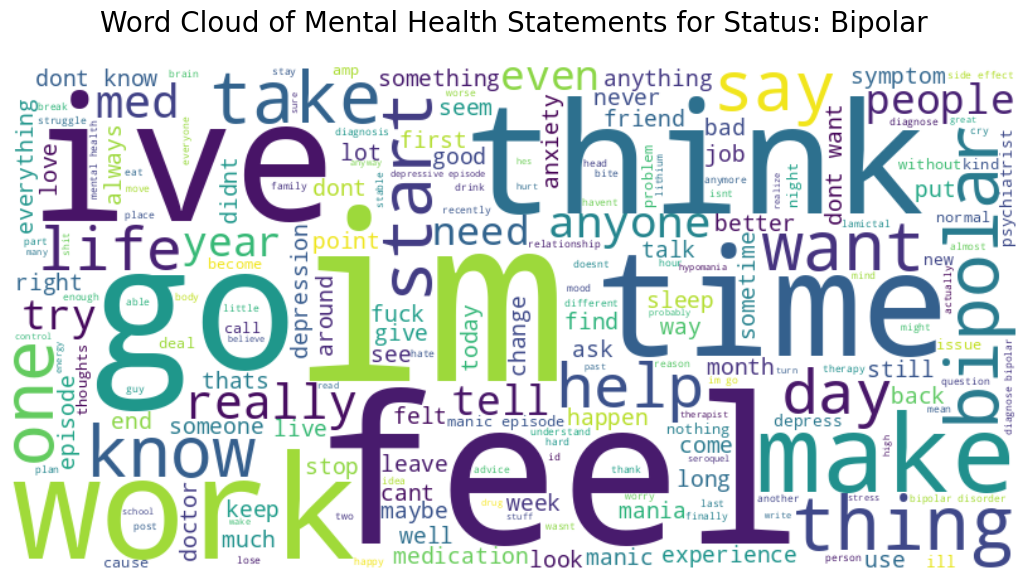

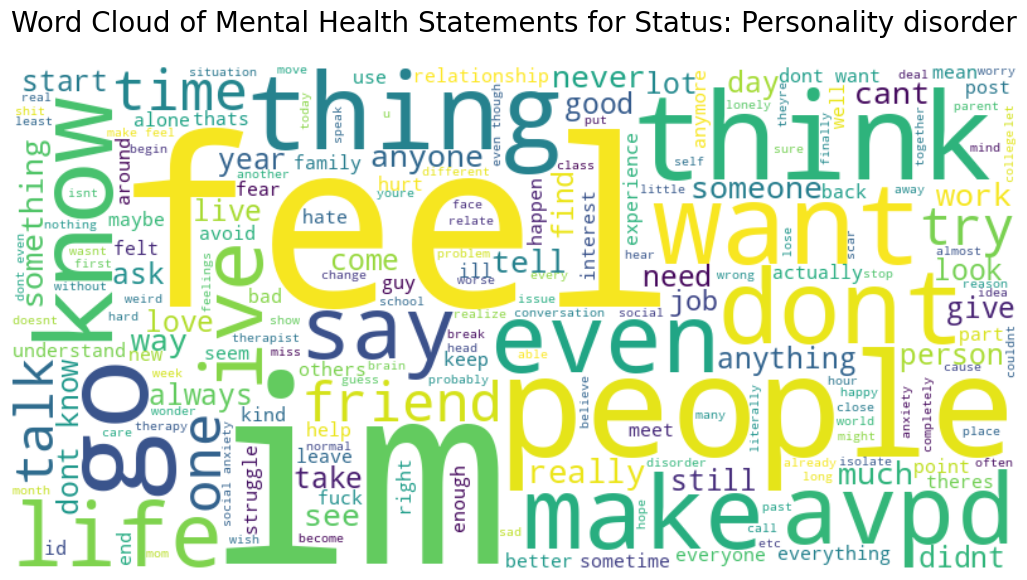

In [18]:
statuses = df_02['status'].unique()

for status in statuses:
    filtered_df = df_02[df_02['status'] == status]

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_df['text_lematized']))

    plt.figure(figsize=(13, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Mental Health Statements for Status: {status}', fontsize=20, pad=25)
    plt.show()


In [19]:
label_encoder = LabelEncoder()

df_02['status_encoded'] = label_encoder.fit_transform(df_02['status'])
df_02.sample(10)

statement      status  \
38455  i m always pointed at when something bad happe...  Depression   
8621   i have been feeling intense physical symptoms ...    Suicidal   
27786  We broke up a month ago because the distance m...      Normal   
15241  The world is crowded with hypocrites. ''When y...    Suicidal   
17553  I have been on anti depressants for the anxiet...  Depression   
47165  vent i don't deserve to be alive i swear to go...  Depression   
6379               Very worn.. I didn't drink at dawn :(      Normal   
40331  hey tbh i don t know who to ask i tried unaliv...  Depression   
25958  Fuuuuuuuuuuuucccckkkkkkk me man life is so fuc...    Suicidal   
11564  except family but they only like me out of evo...  Depression   

                                              text_clean  \
38455  [always, pointed, something, bad, happens, nev...   
8621   [feeling, intense, physical, symptoms, depress...   
27786  [broke, month, ago, distance, made, us, misera...   
15241  [world, crowded, hypocrites, live, good, enoug...   
17553  [anti, depressants, anxiety, benefits, constan...   
47165  [vent, dont, deserve, alive, swear, god, im, f...   
6379                          [worn, didnt, drink, dawn]   
40331  [hey, tbh, know, ask, tried, unalive, hanging,...   
25958  [fuuuuuuuuuuuucccckkkkkkk, man, life, fucking,...   
11564  [except, family, like, evolutionary, reasons, ...   

                                          text_lematized  status_encoded  
38455  always point something bad happen never know b...               2  
8621   feel intense physical symptoms depression tell...               6  
27786  break month ago distance make us miserable lon...               3  
15241  world crowd hypocrites live good enough dead p...               6  
17553  anti depressants anxiety benefit constant hear...               2  
47165  vent dont deserve alive swear god im fuck fuck...               2  
6379                               wear didnt drink dawn               3  
40331  hey tbh know ask try unalive hang un fortunate...               2  
25958  fuuuuuuuuuuuucccckkkkkkk man life fuck pointle...               6  
11564  except family like evolutionary reason hormone...               2

In [20]:
X = df_02['text_lematized']
y = df_02['status_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorization

In [21]:
# vectorizer = CountVectorizer(max_features=75000, ngram_range=(1, 2))
# X_train_counts = vectorizer.fit_transform(X_train)
# X_test_counts = vectorizer.transform(X_test)

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.7, max_features=75_000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Solving unbalanced classes

In [22]:
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_counts, y_train)

# Modelling

In [23]:
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    # min_child_weight=5,
    min_child_weight=3,
    # subsample=0.8,
    subsample=0.6,
    random_state=42,
    tree_method='hist'
)
model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [24]:
y_pred = model.predict(X_test_counts)
labels = label_encoder.classes_

print("Clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred, target_names=labels))

Clasificación en el conjunto de prueba:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       696
             Bipolar       0.83      0.79      0.81       499
          Depression       0.78      0.66      0.71      2992
              Normal       0.83      0.90      0.86      2235
Personality disorder       0.63      0.63      0.63       178
              Stress       0.50      0.65      0.56       458
            Suicidal       0.66      0.71      0.68      2102

            accuracy                           0.74      9160
           macro avg       0.72      0.73      0.72      9160
        weighted avg       0.75      0.74      0.74      9160



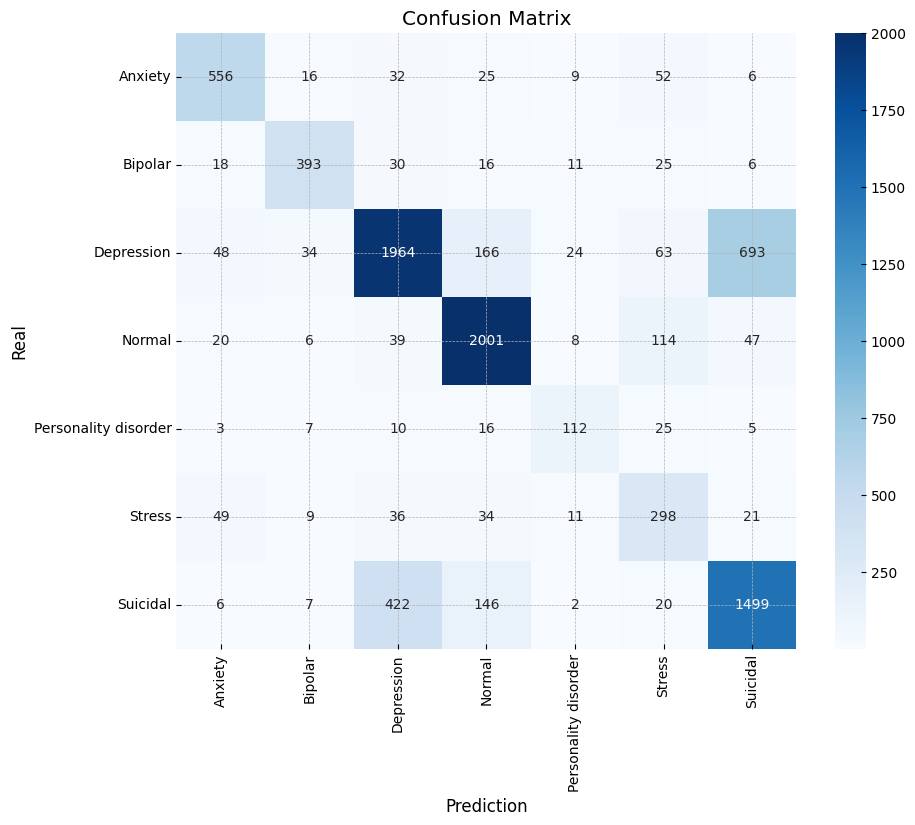

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Real')
plt.xlabel('Prediction')
plt.show()

In [26]:
import pickle

pickle.dump(model, open('mental_health_model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [27]:
from google.colab import files
files.download('mental_health_model.pkl')
files.download('vectorizer.pkl')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>